## Parametros

In [1]:
codigo_canhero = 8711

## Librerias

In [3]:
from werkzeug.wrappers import Request, Response
#from flask import Flask, render_template
from jinja2 import Template

#from datetime import date
from datetime import datetime, timedelta

import collections
from amigocloud import AmigoCloud

## Conectar a AmigoCloud

In [4]:
# CONECTAR A AMIGOCLOUD
acceso = open('../api_key/api.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

## Datos de crédito

In [5]:
query_credito = {'query': 'select * from dataset_282969 where cast(split_part(canhero, \' / \', 1) as integer) = {cod_ca}'.format(cod_ca=codigo_canhero)}
credito_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/31360/sql', query_credito)
credito_data = credito_select['data'][0]

credito_data['fecha_informe'] = (datetime.strptime(credito_data['fecha_2da_insp'].split(' ')[0], '%Y-%m-%d') + timedelta(days=1)).strftime('%d/%m/%Y')
credito_data['fecha_2da_insp'] = datetime.strptime(credito_data['fecha_2da_insp'].split(' ')[0], '%Y-%m-%d').strftime('%d/%m/%Y')
credito = collections.namedtuple("credito", credito_data.keys())(*credito_data.values())
print('end')

end


In [6]:
credito

credito(fecha_registro='2022-01-19 15:41:59+00:00', semana_1ra=None, semana_2da='S34', institucion=68, canhero='8711 / MEJIA QUIMAYA JOSE', solicitado=6.0, fecha_1ra_insp=None, citte_1ra_insp=None, respon_1ra_insp=None, total_1ra_insp=None, estado_1ra_insp='2da INSPECCION', obs_1ra=None, link_doc_1ra=None, fecha_2da_insp='25/08/2022', citte_2da_insp=480, respon_2da_insp='Rogelio Acuña Rodríguez', total_2da_insp=3.46, nacido=3.46, no_nacido=None, estado_2da_insp='APROBADO', obs_2da=None, link_doc_2da='https://drive.google.com/file/d/1S0xpRijI9nI8s-FOIDgaMkjt8YRI9JZD/view?usp=sharing', fecha_actualizacion='2022-08-29 15:51:15.916149+00:00', fertilizacion=False, fungi_en_siem=False, insec_en_siem=True, promot_de_brota=True, pre_emergente=True, post_emergente=True, cultivado=True, ctrl_bio_tricho=True, insect_fisio_otros=False, ctrl_malezas=True, nivelacion=False, drenajes=False, amigo_id='c40e16082688411bb7a4addc8c3c3cc5', muestreo=False, glifosato=False, nivelacion_1=False, drenaje=False

## Datos de propiedades

In [7]:
#query_propiedades = {'query': 'select * from dataset_282968 where cre_ref_prop = \'{cre_ref_prop}\''.format(cre_ref_prop=credito.amigo_id)}
query_propiedades = {'query': 'select prop.propiedad, prop.amigo_id from dataset_282968 prop inner join dataset_282975 lotes on lotes.prop_ref_lote=prop.amigo_id where cre_ref_prop=\'{cre_ref_prop}\' and (lotes.estado_de_siembra=\'CAÑA NACIDA\' or lotes.estado_de_siembra=\'CAÑA NO NACIDA\') group by prop.propiedad, prop.amigo_id'.format(cre_ref_prop=credito.amigo_id)}
propiedades_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/31360/sql', query_propiedades)
propiedades_data = propiedades_select['data']
print('end')

end


In [8]:
propiedades_data

[{'propiedad': '1077 / P-006 COOP.AGRIC. DE P.GUALBERTO V--MEJIA',
  'amigo_id': '0470575bf3044095be0f65de884ed2b7'}]

## Datos de lotes

In [9]:
propiedades = []
for prop in propiedades_data:
    prop['lotes'] = []
    query_lotes = {'query': 'select * from dataset_282975 where prop_ref_lote=\'{prop_ref_lote}\' and (estado_de_siembra=\'CAÑA NACIDA\' or estado_de_siembra=\'CAÑA NO NACIDA\')'.format(prop_ref_lote=prop['amigo_id'])}
    lotes_select = amigocloud.get('https://app.amigocloud.com/api/v1/projects/31360/sql', query_lotes)
    for lote_select in lotes_select['data']:
        lote = collections.namedtuple("lote", lote_select.keys())(*lote_select.values())
        prop['lotes'].append(lote)
    propiedades.append(collections.namedtuple("propiedad", prop.keys())(*prop.values()))
print('end')

end


In [10]:
propiedades

[propiedad(propiedad='1077 / P-006 COOP.AGRIC. DE P.GUALBERTO V--MEJIA', amigo_id='0470575bf3044095be0f65de884ed2b7', lotes=[lote(prop_ref_lote='0470575bf3044095be0f65de884ed2b7', geometria='0106000020E61000000100000001030000000100000005000000C9E0CDBF028B4FC0FEC2E1BB831E31C0E8386D7CDC8A4FC04DD9E907751F31C02A06A3EDF38A4FC0097657D17A1F31C0D32C75351E8B4FC01887E931801E31C0C9E0CDBF028B4FC0FEC2E1BB831E31C0', fecha_registro='2022-08-24 19:09:34+00:00', lote='L5', superficie=3.46, textura='F', lote_semillero=None, variedad_semillero=None, variedad_sugerida=None, estado_semillero=None, mes_siembra=None, variedad_sembrada='UCG 90-20', fecha_siembra='2022-06-27 13:12:50+00:00', estado_de_siembra='CAÑA NACIDA', obs=None, fecha_actualizacion='2022-08-29 14:49:35.059200+00:00', amigo_id='539bdec80e6f4993bb836cde94c03cb0', obs_2=None)])]

## Fotos

In [11]:
fotos = []
for propiedad in propiedades:
    for lote in propiedad.lotes:
        print(lote.lote, lote.amigo_id)
        query_fotos = {'query': 'select source_amigo_id, s3_filename from gallery_41588 where source_amigo_id=\'{source_amigo_id}\''.format(source_amigo_id=lote.amigo_id)}
        fotos_filename = amigocloud.get('https://app.amigocloud.com/api/v1/projects/31360/sql', query_fotos)
        if fotos_filename['data'] != []:
            dic = {'lote': lote.lote, 'file_name': fotos_filename['data'][0]['s3_filename']}
            fotos.append(dic)
fotos

L5 539bdec80e6f4993bb836cde94c03cb0


[{'lote': 'L5', 'file_name': 'WhatsApp Image 2022-08-24 at 3.13.09 PM.jpeg'}]

## Recorrido de las propiedades y lotes

In [12]:
for prop in propiedades:
    print(prop.propiedad)
    for lote in prop.lotes:
        print(lote.lote)

1077 / P-006 COOP.AGRIC. DE P.GUALBERTO V--MEJIA
L5


In [13]:
credito

credito(fecha_registro='2022-01-19 15:41:59+00:00', semana_1ra=None, semana_2da='S34', institucion=68, canhero='8711 / MEJIA QUIMAYA JOSE', solicitado=6.0, fecha_1ra_insp=None, citte_1ra_insp=None, respon_1ra_insp=None, total_1ra_insp=None, estado_1ra_insp='2da INSPECCION', obs_1ra=None, link_doc_1ra=None, fecha_2da_insp='25/08/2022', citte_2da_insp=480, respon_2da_insp='Rogelio Acuña Rodríguez', total_2da_insp=3.46, nacido=3.46, no_nacido=None, estado_2da_insp='APROBADO', obs_2da=None, link_doc_2da='https://drive.google.com/file/d/1S0xpRijI9nI8s-FOIDgaMkjt8YRI9JZD/view?usp=sharing', fecha_actualizacion='2022-08-29 15:51:15.916149+00:00', fertilizacion=False, fungi_en_siem=False, insec_en_siem=True, promot_de_brota=True, pre_emergente=True, post_emergente=True, cultivado=True, ctrl_bio_tricho=True, insect_fisio_otros=False, ctrl_malezas=True, nivelacion=False, drenajes=False, amigo_id='c40e16082688411bb7a4addc8c3c3cc5', muestreo=False, glifosato=False, nivelacion_1=False, drenaje=False

# Sección de planos

# ------------------------------------------------------------------------------------------

In [14]:
from shapely import wkb
import geopandas
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt

def convertir_wkb(wkb_data):
    return wkb.loads(wkb_data, hex=True)[0]


In [15]:
propiedades

[propiedad(propiedad='1077 / P-006 COOP.AGRIC. DE P.GUALBERTO V--MEJIA', amigo_id='0470575bf3044095be0f65de884ed2b7', lotes=[lote(prop_ref_lote='0470575bf3044095be0f65de884ed2b7', geometria='0106000020E61000000100000001030000000100000005000000C9E0CDBF028B4FC0FEC2E1BB831E31C0E8386D7CDC8A4FC04DD9E907751F31C02A06A3EDF38A4FC0097657D17A1F31C0D32C75351E8B4FC01887E931801E31C0C9E0CDBF028B4FC0FEC2E1BB831E31C0', fecha_registro='2022-08-24 19:09:34+00:00', lote='L5', superficie=3.46, textura='F', lote_semillero=None, variedad_semillero=None, variedad_sugerida=None, estado_semillero=None, mes_siembra=None, variedad_sembrada='UCG 90-20', fecha_siembra='2022-06-27 13:12:50+00:00', estado_de_siembra='CAÑA NACIDA', obs=None, fecha_actualizacion='2022-08-29 14:49:35.059200+00:00', amigo_id='539bdec80e6f4993bb836cde94c03cb0', obs_2=None)])]

end


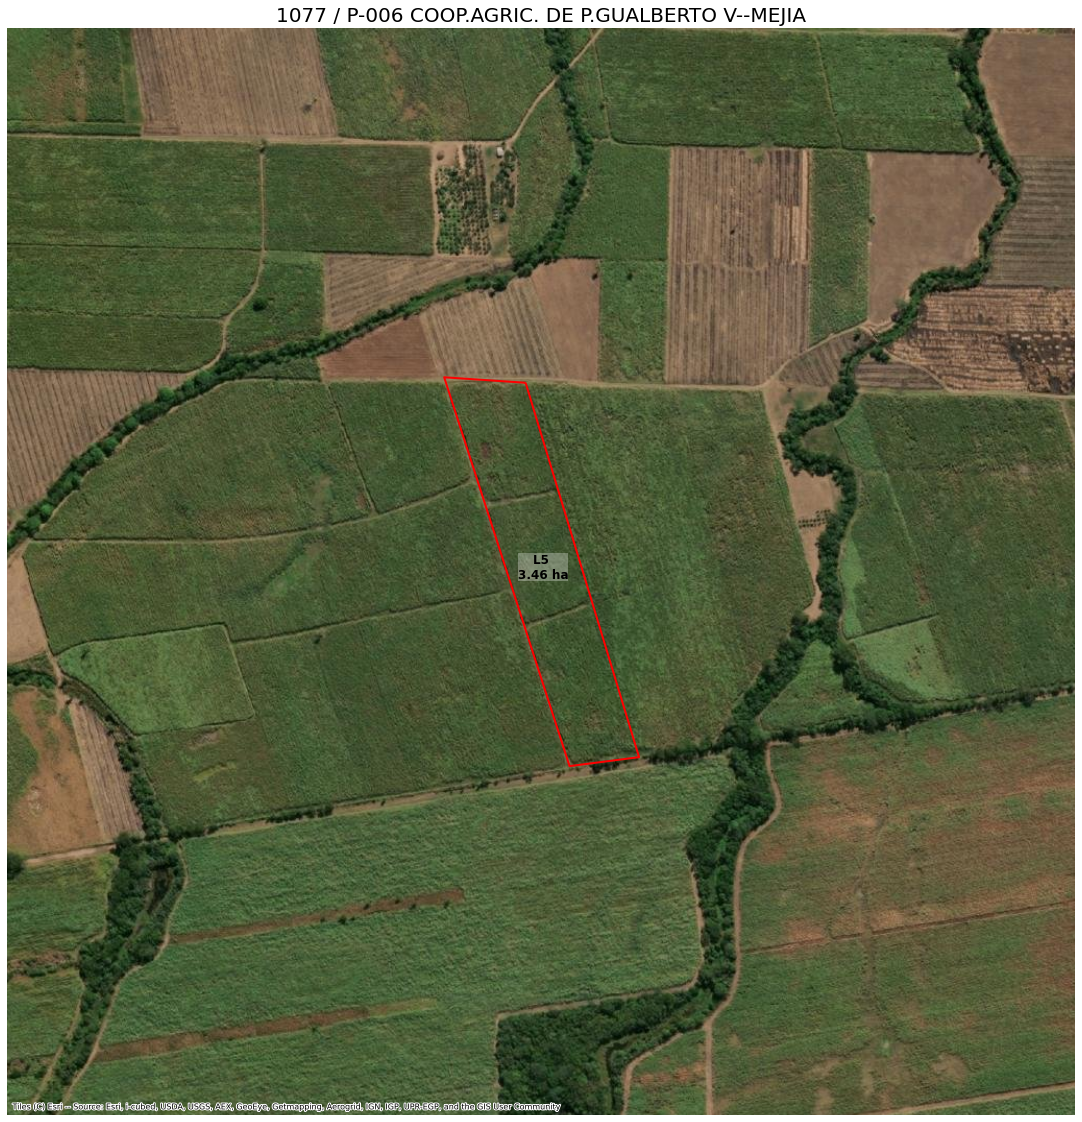

In [16]:
i = 0
lista_planos = []
ruta = ''
for propiedad in propiedades:
    i = i + 1
    lotes_lista = []
    for lote in propiedad.lotes:
        lotes_lista.append(lote._asdict())
    df = pd.DataFrame(lotes_lista)
    df['geometria'] = df['geometria'].apply(convertir_wkb)

    #Convertir a GeoDataFrame
    data = geopandas.GeoDataFrame(df, geometry='geometria')
    #data
    #ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

    data['coords'] = data['geometria'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    data.crs = "EPSG:4326"
    data = data.to_crs(epsg=3857)

    
    fig = plt.figure(i, figsize=(20,20))
    #fig = plt.figure(1)
    ax = None
    ax = fig.add_subplot()

    #data.set_crs(epsg=4326, inplace=True)

    data.apply(lambda x: ax.annotate(text=x.lote + ' \n' + str(x.superficie) + ' ha', xy=x.geometria.centroid.coords[0], ha='center', va='center', color='black', fontsize=12, weight=1000, bbox=dict(facecolor=(1,1,1,0.3), edgecolor='none', pad=0)), axis=1);

    #data.boundary.plot(ax=ax, color=(0,0,0,0), linewidth=0)

    #data = data.to_crs(epsg=3857)

    minx, miny, maxx, maxy = data.total_bounds
    ax.set_xlim(minx - 500, maxx + 500)
    ax.set_ylim(miny - 400, maxy + 400)

    data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2, figsize=(20,20))
    #data.plot(ax=ax, edgecolor='r', facecolor=(0,0,0,0), linewidth=2)
    
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    ax.set_axis_off()
    ax.set_title(propiedad.propiedad, fontsize=20)
    ruta = 'planos/' + str(credito.amigo_id) + '_' + str(propiedad.amigo_id) + '.jpeg'
    lista_planos.append(ruta)
    fig.savefig(ruta, dpi = 300, bbox_inches='tight')
    del fig
print('end')

In [19]:
fotos

[{'lote': 'L5', 'file_name': 'WhatsApp Image 2022-08-24 at 3.13.09 PM.jpeg'}]

In [20]:
credito

credito(fecha_registro='2022-01-19 15:41:59+00:00', semana_1ra=None, semana_2da='S34', institucion=68, canhero='8711 / MEJIA QUIMAYA JOSE', solicitado=6.0, fecha_1ra_insp=None, citte_1ra_insp=None, respon_1ra_insp=None, total_1ra_insp=None, estado_1ra_insp='2da INSPECCION', obs_1ra=None, link_doc_1ra=None, fecha_2da_insp='25/08/2022', citte_2da_insp=480, respon_2da_insp='Rogelio Acuña Rodríguez', total_2da_insp=3.46, nacido=3.46, no_nacido=None, estado_2da_insp='APROBADO', obs_2da=None, link_doc_2da=None, fecha_actualizacion='2022-08-29 14:46:16.471030+00:00', fertilizacion=False, fungi_en_siem=False, insec_en_siem=True, promot_de_brota=True, pre_emergente=True, post_emergente=True, cultivado=True, ctrl_bio_tricho=True, insect_fisio_otros=False, ctrl_malezas=True, nivelacion=False, drenajes=False, amigo_id='c40e16082688411bb7a4addc8c3c3cc5', muestreo=False, glifosato=False, nivelacion_1=False, drenaje=False, romeplow=False, rastra=False, subsolado=False, rotacion=False, arado=False, fe

In [21]:
from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm

import requests

doc = DocxTemplate("templates/template_word_2da.docx")

#generar lista de InlineImage de planos
lista_InlineImage = []
for plano in lista_planos:
    lista_InlineImage.append(docxtpl.InlineImage(doc, image_descriptor=plano, width=Mm(150)))

#descargar fotos y generar lista InlineImage
lista_fotos_inline = []
for foto in fotos:
    #response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    response = requests.get("https://www-amigocloud.s3.amazonaws.com/gallery/" + foto['file_name'])
    file = open('fotos/' + foto['file_name'], "wb")
    file.write(response.content)
    file.close()
    lista_fotos_inline.append({'foto': docxtpl.InlineImage(doc, image_descriptor='fotos/' + foto['file_name'], width=Mm(70)), 'lote': foto['lote']})

firma_respon = None
if credito.respon_2da_insp == 'Rogelio Acuña Rodríguez':
    firma_respon = docxtpl.InlineImage(doc, image_descriptor='templates/firma_rogelio.png', width=Mm(60))
else:
    firma_respon = docxtpl.InlineImage(doc, image_descriptor='templates/firma_jaldin.png', width=Mm(60))

context = {'credito':credito, 'propiedades':propiedades, 'planos':lista_InlineImage, 'fotos':lista_fotos_inline, 'firma':firma_respon}

doc.render(context)
file_name = credito.canhero.replace(' / ', '_')
doc.save('_' + file_name + '.docx')